In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#### The best results were achieved with the model SVR with neural network weights as sample_weights
* SVR MSE: 0.04857954650262728 
* 
SVR MAE: 0.1532534225575731
* SVR R2 Score: 0.6047223720917043343

In [2]:
# Loading the dataset into a pandas DataFrame
data=pd.read_csv("books_train_dataset.csv")

This was the result of our feature importance

 ```
 feature  importance
7       authors_average_rating    0.544057
2                    num_pages    0.065277
6                ratings_count    0.053819
9        authors_ratings_count    0.051213
0                 title_length    0.050418
8   authors_text_reviews_count    0.046230
5             publication_year    0.037195
1           text_reviews_count    0.033718
3              publication_day    0.033663
4            publication_month    0.028348
11               language_code    0.018149
14                    is_comic    0.009389
15       is_fantasy_paranormal    0.005413
17   is_mystery_thriller_crime    0.004677
12                    is_ebook    0.004349
19                  is_romance    0.003988
16        is_history_biography    0.003953
13                 is_children    0.003327
20              is_young_adult    0.002565
18                   is_poetry    0.000253
10                country_code    0.000000

```



We will exclude contry_code since its feature importance is 0

In [3]:
books_df=data.copy()
# Step 1: Remove low importance features
features = [
    'title_length', 'text_reviews_count', 'num_pages', 'publication_day',
    'publication_month', 'publication_year', 'ratings_count',
    'authors_average_rating', 'authors_text_reviews_count',
    'authors_ratings_count',  'language_code', 'is_ebook',
     'is_children', 'is_comic',
    'is_fantasy_paranormal', 'is_history_biography', 'is_mystery_thriller_crime',
    'is_poetry', 'is_romance', 'is_young_adult'
]

X = books_df[features]
y = books_df['average_rating']

In [4]:
# Splitting the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Calculating the performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score
# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2, rmse

(0.5303973281060648, 0.057714080500204976)

R2: 53% and RMSE (Root Mean Square Error) suggest that the models predictions are moderate overall

In [14]:
# Scaling features to use for neural network model training and testing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Neural Network Model

Epoch 1/50
2704/2704 [==============================] - 4s 1ms/step - loss: 0.6679 - mae: 0.5015 - val_loss: 0.0793 - val_mae: 0.2197
Epoch 2/50
2704/2704 [==============================] - 4s 1ms/step - loss: 0.0781 - mae: 0.2012 - val_loss: 0.0668 - val_mae: 0.1915
Epoch 3/50
2704/2704 [==============================] - 4s 1ms/step - loss: 0.0813 - mae: 0.1844 - val_loss: 0.0629 - val_mae: 0.1856
Epoch 4/50
2704/2704 [==============================] - 4s 1ms/step - loss: 0.0741 - mae: 0.1819 - val_loss: 0.0578 - val_mae: 0.1769
Epoch 5/50
2704/2704 [==============================] - 4s 1ms/step - loss: 0.0597 - mae: 0.1760 - val_loss: 0.0593 - val_mae: 0.1770
Epoch 6/50
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0585 - mae: 0.1748 - val_loss: 0.0584 - val_mae: 0.1792
Epoch 7/50
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0582 - mae: 0.1734 - val_loss: 0.0585 - val_mae: 0.1773
Epoch 8/50
2704/2704 [==============================] - 5s 2ms

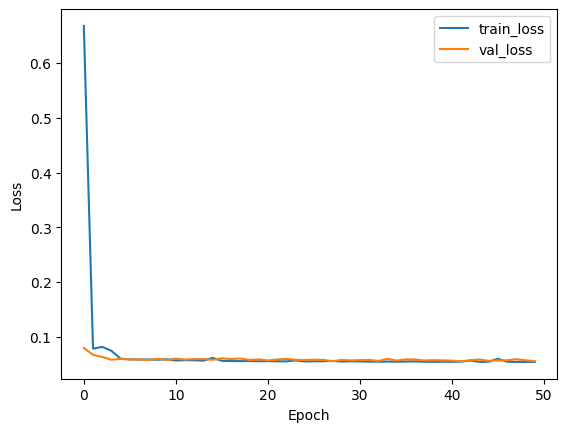

In [33]:
# Building a Neural Network Model
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dropout(0.2)(x)  # Dropout to prevent overfitting
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)
# Compiling the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training the Model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluating the Model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

# Plotting the training history to see if we had an overfitting
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### SVR (Support Vector Regression) with neural network weights

In [23]:
# Calculating the performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score
from sklearn.svm import SVR

# predicted values from the neural network
nn_predictions = y_pred

# Taking the weights from nn predictions
weights = nn_predictions.flatten()

# SVR model with a weighted kernel
svr_model = SVR(kernel='rbf', gamma='scale', C=1.0)

# SVR model with the neural network weights
svr_model.fit(X_test_scaled, y_test, sample_weight=weights)

# Prediction
y_pred_svr = svr_model.predict(X_test_scaled)

# Model Evaluation
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'SVR MSE: {mse_svr}')
print(f'SVR MAE: {mae_svr}')
print(f'SVR R2 Score: {r2_svr}')


SVR MSE: 0.04857954650262728
SVR MAE: 0.15325342255757313
SVR R2 Score: 0.6047223720917043


### Random Forest

In [36]:
# Calculating the performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score
from sklearn.ensemble import RandomForestRegressor

# Train & Prediction
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MSE: {mse_rf}')
print(f'Random Forest MAE: {mae_rf}')
print(f'Random Forest R2 Score: {r2_rf}')


Random Forest MSE: 0.04987490962021743
Random Forest MAE: 0.15688171185498645
Random Forest R2 Score: 0.5941823794968117


### xgboost Model

In [37]:
# Calculating the performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
ma_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_rf)

print(f'Xgboost MSE: {mse_xgb}')
print(f'Xgboost MAE: {ma_xgb}')
print(f'Xgboost R2 Score: {r2_xgb}')


Xgboost MSE: 0.05176939679411949
Xgboost MAE: 0.16085344015557937
Xgboost R2 Score: 0.5941823794968117


### Lightgbm Model

In [38]:
# Calculating the performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, force_row_wise=True)

lgb_model.fit(X_train_scaled, y_train)

y_pred_lgb = lgb_model.predict(X_test_scaled)

mse_lgb = mean_squared_error(y_test, y_pred_lgb)
ma_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_rf)

print(f'Lightgbm MSE: {mse_lgb}')
print(f'Lightgbm MAE: {ma_lgb}')
print(f'Lightgbm R2 Score: {r2_lgb}')


[LightGBM] [Info] Total Bins 1795
[LightGBM] [Info] Number of data points in the train set: 108152, number of used features: 20
[LightGBM] [Info] Start training from score 3.908001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Lightgbm MSE: 0.051800954060962696
Lightgbm MAE: 0.16111313982076045
Lightgbm R2 Score: 0.5941823794968117


### SVR without nn weights

In [19]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

svr_model.fit(X_train_scaled, y_train)

y_pred_svr = svr_model.predict(X_test_scaled)

SVR Mean Absolute Error: 0.16247001949631923


In [20]:
# Calculating the performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'SVR MSE: {mse_svr}')
print(f'SVR MAE: {mae_svr}')
print(f'SVR R2 Score: {r2_svr}')


SVR MSE: 0.053667300612177594
SVR MAE: 0.16247001949631923
SVR R2 Score: 0.5633247979975334


### CatBoost Model

In [26]:
# Training a CatBoost Regressor model with 100 estimators, a learning rate of 0.1, and max depth of 6
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

catboost_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=6, random_state=42, verbose=0)

catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)

In [27]:
# Calculating the performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print(f'Catboost MSE: {mse_catboost}')
print(f'Catboost MAE: {mae_catboost}')
print(f'Catboost R2 Score: {r2_catboost}')

Catboost MSE: 0.053309075794678175
Catboost MAE: 0.16352599129296128
Catboost R2 Score: 0.5662395690547601


### KNeighbors model

In [28]:
# Training a K-Nearest Neighbors Regressor with 5 neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'knn MSE: {mse_knn}')
print(f'knn MAE: {mae_knn}')
print(f'knn R2 Score: {r2_knn}')


knn MSE: 0.06563499652650429
knn MAE: 0.18727928200038835
knn R2 Score: 0.46594714025659467
